# `cmip6_preprocessing` demo for AWS webinar

I am running this from the Pangeo deployment on AWS (more infos [here](https://pangeo.io/cloud.html#)).

In [36]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 12, 6
%config InlineBackend.figure_format = 'retina'

## Request Dask Cluster for parallel processing of the data

This notebook server does not have enough cores to efficiently work with the data, so lets get a dask cluster set up first:

In [6]:
from dask_gateway import GatewayCluster
from distributed import Client

cluster = GatewayCluster()
cluster.scale(30)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/icesat2-staging.6a08be5697fb4e5fb7bed8fa7e70597e/status,


## Load and clean the data

For this example we use a catalog of CMIP6 zarr files, maintained by the Pangeo Project, and hosted publicly on S3. For more info on the pangeo CMIP6 data click [here](https://pangeo-data.github.io/pangeo-cmip6-cloud/).

This example uses the custom intake-esm catalog provided, but all functions shown here can be applied to an xarray dataset directly

In [37]:
import intake
url = "https://cmip6-pds.s3.amazonaws.com/pangeo-cmip6.json"
col = intake.open_esm_datastore(url)

In [38]:
# This function is the 'all-in-one' cleaning component of cmip6_preprocessing
from cmip6_preprocessing.preprocessing import combined_preprocessing

selected_models = ["IPSL-CM6A-LR", "ACCESS-ESM1-5", 'GFDL-ESM4', 'CESM2', 'MPI-ESM1-2-LR']

query = dict(
    experiment_id=["historical", "ssp585"],
    source_id=selected_models,
)

kwargs = dict(
    zarr_kwargs={"consolidated": True, "use_cftime": True},
    preprocess=combined_preprocessing, # This is the only modification needed
    aggregate=False,
    storage_options={'anon':True},
    
)

# load two dataset dictionaries: One for the surface temperature and another
# for the horizontal grid area

dset_dict = col.search(
    variable_id="tos",
    member_id=["r4i1p1f1", "r3i1p1f1", "r5i1p1f1","r2i1p1f1","r1i1p1f1"],
    table_id="Omon",
    **query
).to_dataset_dict(**kwargs)

metric_dict = col.search(
    variable_id="areacello",
    **query
).to_dataset_dict(**kwargs)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


## Postprocessing - Combining datasets for final analysis

Now we will add the metrics (horizontal cell area) and concatenate the members of each model into 

In [39]:
from cmip6_preprocessing.postprocessing import match_metrics, concat_members

dset_dict_w_metrics = match_metrics(dset_dict, metric_dict, ['areacello'])
dset_dict_combined = concat_members(dset_dict_w_metrics)

In [40]:
dset_dict_combined['CESM2.gn.historical.Omon']

<xarray.Dataset>
Dimensions:        (y: 384, x: 320, vertex: 4, time: 1980, bnds: 2, member_id: 5)
Coordinates: (12/13)
    lat            (y, x) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
    lat_verticies  (y, x, vertex) float32 -79.49 -78.95 -78.95 ... 72.41 71.96
    lon            (y, x) float64 320.6 321.7 322.8 323.9 ... 318.9 319.4 319.8
    lon_verticies  (y, x, vertex) float32 320.0 320.0 321.1 ... 320.0 320.0
  * y              (y) int32 1 2 3 4 5 6 7 8 ... 377 378 379 380 381 382 383 384
  * x              (x) int32 1 2 3 4 5 6 7 8 ... 313 314 315 316 317 318 319 320
    ...             ...
    time_bounds    (time, bnds) object 1850-01-01 02:00:00.000003 ... 2015-01...
  * vertex         (vertex) int64 0 1 2 3
  * bnds           (bnds) int64 0 1
    lon_bounds     (bnds, y, x) float32 320.0 321.1 322.2 ... 319.1 319.6 320.0
    lat_bounds     (bnds, y, x) float32 -79.49 -79.49 -79.49 ... 72.42 72.41
    areacello      (y, x) float32 1.125e+09 1.125e+09 ... 7.431e+08 7.432e+08
Dimensions without coordinates: member_id
Data variables:
    tos            (member_id, time, y, x) float32 dask.array<chunksize=(1, 403, 384, 320), meta=np.ndarray>
Attributes: (12/40)
    Conventions:           CF-1.7 CMIP-6.2
    activity_id:           CMIP
    branch_method:         standard
    branch_time_in_child:  674885.0
    contact:               cesm_cmip6@ucar.edu
    data_specs_version:    01.00.29
    ...                    ...
    table_id:              Omon
    variable_id:           tos
    variant_info:          CMIP6 20th century experiments (1850-2014) with CA...
    status:                2019-10-25;created;by nhn2@columbia.edu
    version_id:            v20190308
    intake_esm_varname:    None

Text(0, 0.5, 'Global Average Sea Surface Temperature')

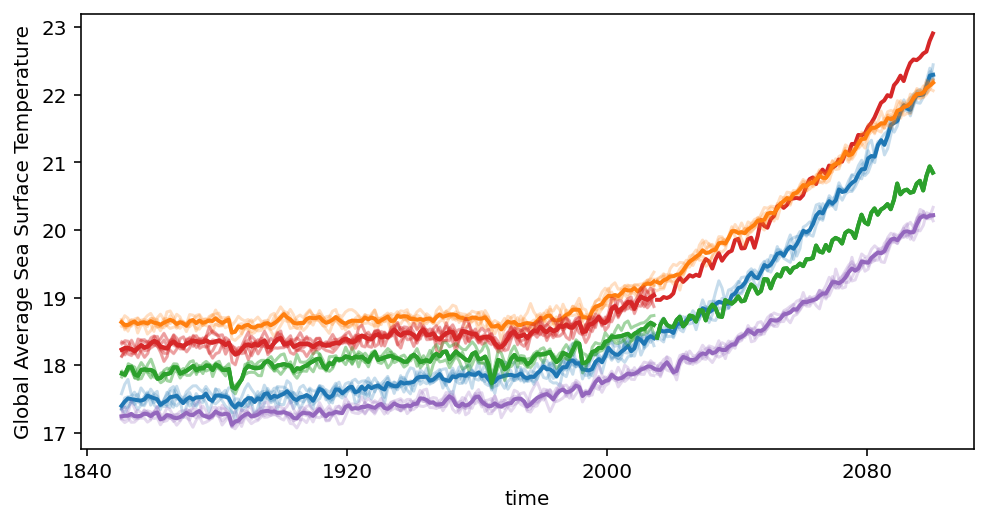

In [41]:
import matplotlib.pyplot as plt

color_dict = {k:f"C{ki}" for ki, k in enumerate(selected_models)}

plt.figure(figsize=[8,4])
for ni, (name, ds) in enumerate(dset_dict_combined.items()):
    
    ds = ds.sel(time=slice('1850','2100'))
    # Weighted average of surface ocean temperatures
    sst = ds.tos.weighted(ds.areacello.fillna(0)).mean(['x','y'])
    # average over 2 years
    sst = sst.coarsen(time=12).mean()
    
    ### Plotting ###
    color = color_dict[ds.source_id]
    # plot single members
    sst.plot(hue='member_id', color=color, label=name, add_legend=False, alpha=0.25)
    # plot member average
    sst.mean('member_id').plot(linewidth=2, color=color,add_legend=False)
    
plt.ylabel('Global Average Sea Surface Temperature')